In [1]:
import sys 
sys.path.append('../')
from tqdm import tqdm

import jax 
import jax.numpy as jnp 
import numpy as np
rng_np = np.random.default_rng(1)

from jaxlie import SE3, SO3
from jax.random import normal
from jax import grad, hessian, vmap, jit
from jax.lax import scan
from jax.scipy.stats import multivariate_normal as mvn

from functools import partial
import jax.random as jax_random
import matplotlib.pyplot as plt 
from IPython.display import clear_output
from plyfile import PlyData
import open3d as o3d 
import trimesh as tm
import trimesh
import time
import jaxopt
import polyscope as ps


import meshcat
import meshcat.geometry as mc_geom

from ergodic_mmd.aug_lagrange_jaxopt import AugmentedLagrangeSolver
# from ergodic_mmd.aug_lagrange_solver import AugmentedLagrangeSolver


/Users/ia285/miniconda3/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
objc[78936]: Class GLFWApplicationDelegate is implemented in both /Users/ia285/miniconda3/lib/python3.10/site-packages/open3d/cpu/pybind.cpython-310-darwin.so (0x176416e28) and /Users/ia285/miniconda3/lib/python3.10/site-packages/polyscope_bindings.cpython-310-darwin.so (0x298dcee68). One of the two will be used. Which one is undefined.
objc[78936]: Class GLFWWindowDelegate is implemented in both /Users/ia285/miniconda3/lib/python3.10/site-packages/open3d/cpu/pybind.cpython-310-darwin.so (0x176416db0) and /Users/ia285/miniconda3/lib/python3.10/site-packages/polyscope_bindings.cpython-310-darwin.so (0x298dcee90). One of the two will be used. Which one is undefined.
objc[78936]: Class GLFWContentView is implemented in both /Users

In [256]:
mean1 = jnp.array([0.35, 0.38])
cov1 = jnp.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w1 = 0.5

mean2 = jnp.array([0.68, 0.25])
cov2 = jnp.array([
    [0.005, -0.003],
    [-0.003, 0.005]
])
w2 = 0.2

mean3 = jnp.array([0.56, 0.64])
cov3 = jnp.array([
    [0.008, 0.0],
    [0.0, 0.004]
])
w3 = 0.3

@jit
def pdf(x):
    return w1 * mvn.pdf(x, mean1, cov1) + \
           w2 * mvn.pdf(x, mean2, cov2) + \
           w3 * mvn.pdf(x, mean3, cov3)


# Define a 1-by-1 2D search space
L_list = np.array([1.0, 1.0])  # boundaries for each dimension

# Discretize the search space into 100-by-100 mesh grids
grids_x, grids_y = np.meshgrid(
    np.linspace(0, L_list[0], 100),
    np.linspace(0, L_list[1], 100)
)
grids = np.array([grids_x.ravel(), grids_y.ravel()]).T
dx = 1.0 / 99
dy = 1.0 / 99 

pdf_vals = pdf(grids)  # for visualizing the PDF
pdf_norm = np.sum(pdf_vals * pdf_vals) * dx * dy  # PDF norm for the kernel ergodic metric

# Sample from the spatial distribution
rng = jax.random.PRNGKey(12)
num_samples = 100
target_samples = jnp.vstack([
    jax.random.multivariate_normal(rng, mean=mean1, cov=cov1, shape=(int(num_samples*w1),)),
    jax.random.multivariate_normal(rng, mean=mean2, cov=cov2, shape=(int(num_samples*w2),)),
    jax.random.multivariate_normal(rng, mean=mean3, cov=cov3, shape=(int(num_samples*w3),))
])

points = target_samples
P_XI = vmap(pdf)(target_samples)
P_XI = P_XI/jnp.sum(P_XI)


In [257]:
def F_forward(x, u, dt):
    xp = x + dt * u
    return xp, x

forward_sim = lambda x0, u, dt: scan(partial(F_forward,dt=dt), x0, u)

def RBF_kernel(x, xp, h=0.01):
    return jnp.exp(
        -jnp.exp(h)@(x-xp)**2
    )

def create_kernel_matrix(kernel):
    return vmap(vmap(kernel, in_axes=(0, None, None)), in_axes=(None, 0, None))

KernelMatrix = create_kernel_matrix(RBF_kernel)
def emmd_loss(params, args):
    # X = params['X']
    U = params['U']
    X = forward_sim(args['x0'], U, args['dt'])[1]
    # X = jnp.vstack([X, args['x0']])

    T = X.shape[0]
    h = args['h']
    points    = args['points']
    P_XI      = args['P_XI']

    return np.sum(KernelMatrix(X, X, h))/(T**2) \
            - 2 * np.sum(P_XI @ KernelMatrix(X, points, h))/T + 1e-3*np.mean(U**2)

def fast_kernel_loss(params, args):
    # X = params['X']
    U = params['U']
    X = forward_sim(args['x0'], U, args['dt'])[1]
    # X = jnp.vstack([X, args['x0']])
    T = X.shape[0]
    h = args['h']
    points    = args['points']
    P_XI      = args['P_XI']

    return np.sum(KernelMatrix(X, X, h))/(T**2) \
            - 2 * np.sum(vmap(pdf)(X))/T + 1e-3*np.mean(U**2)

def eq_constr(params, args):
    # X = params['X']
    U = params['U']
    # q0 = args['q0']
    return jnp.zeros(1)
    # return jnp.vstack([
    #     X[0]-args['x0'],
    #     X[1:] - X[:-1] - args['dt'] * U[:-1],
    #     # X[-1]-args['x0']
    # ])
    # return jnp.hstack([X[0]-q0, X[-1]-q0])

def ineq_constr(params, args):
    # X = params['X']
    U = params['U']
    return jnp.zeros(1)
    # return jnp.vstack([
    #     U-1,
    #     -U-1
    # ])


In [258]:
# Optimize the kernel parameter
from jax.scipy.optimize import minimize 

d2_kernel = jit(grad(RBF_kernel, argnums=(1)))

# Define the kernel ergdic metric over samples
def samples_kernel_metric(theta, samples):
    val1 = vmap(pdf, in_axes=(0,))(samples)
    val2 = vmap(vmap(RBF_kernel, in_axes=(0,None,None)), in_axes=(None,0,None))(samples, samples, theta)
    return -2.0 * jnp.mean(val1) + jnp.mean(val2)

grad_samples_kernel_metric = grad(samples_kernel_metric, argnums=(1))

# Define the objective for optimizing kernel parameters
def parameter_opt_obj(theta, samples):
    dvec = grad_samples_kernel_metric(theta, samples)
    return jnp.sum(jnp.square(dvec))  

theta_sol = minimize(parameter_opt_obj, x0=jnp.array([1.0, 1.0]), args=(target_samples,), method='bfgs')
opt_theta = theta_sol.x
print('optimal kernel parameter: ', opt_theta)

optimal kernel parameter:  [4.42716821 4.01353189]


In [259]:
# h = 0.0025
args = {
        'h' : jnp.array([4.,4.]), 
        'points' : points, 
        'P_XI' : P_XI,
        'dt' : 0.1,
        'x0' : jnp.array([0.7,0.6])
}


In [260]:
T = 100
X = jnp.linspace(args['x0'], args['x0']+0.1, num=T)
X = jnp.array([
    np.linspace(0.0, 0.3, T) * np.cos(np.linspace(0.0, 2*np.pi, T)),
    np.linspace(0.0, 0.3, T) * np.sin(np.linspace(0.0, 2*np.pi, T))
]).T

# generate a spiral trajectory as the initial control
# temp_x_traj = np.array([
#     np.linspace(0.0, 0.3, tsteps+1) * np.cos(np.linspace(0.0, 2*np.pi, tsteps+1)),
#     np.linspace(0.0, 0.3, tsteps+1) * np.sin(np.linspace(0.0, 2*np.pi, tsteps+1))
# ]).T
U = (X[1:, :] - X[:-1, :]) / args['dt']

U = jnp.zeros((T, 2))

params = {'U': U}

solver = AugmentedLagrangeSolver(params, emmd_loss, eq_constr, ineq_constr, args=args, c=.1)
# solver = AugmentedLagrangeSolver(
#     params, emmd_loss, eq_constr, ineq_constr, 
#     step_size=1e-3,
#     args=args)
# 

In [261]:
solver.solve(max_iter=15_000, eps=1e-3)

0 0.35702857952296146
1 0.17458490882350466
2 0.14372009671187944
3 0.1273158831356806
4 0.12444466936813851
5 0.1512043776180069
6 0.20652432214370944
7 0.14768611317869484
8 0.20699605684721004
9 0.13031687901767544
10 0.12413357036794491
11 0.12296365552055544
12 0.1117876281314316
13 0.1665509744399012
14 0.1330738524313237
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-09, Decrease error: 6.710640918483917e-12, Curvature error: 0.00036031725051598765
15 0.13307385242848063
16 0.11844744782441362
17 0.12689787230315747
18 0.10225090515498891
19 0.08096577028290777
20 0.06578628136736898
21 0.05675015594167809
22 0.049952234655936505
23 0.045376426821084
24 0.042400574501778865
25 0.041807841199667566
26 0.04611592763857298
27 0.04978279188214542
28 0.038798767752616335
29 0.04735584674478359
30 0.044557012658470556
31 0.050756386077005076
32 0.02504689014379927
33 0.024630281476781122
34 0.030866552891784235
35 0.056633510840004064
36 0.11283151490683155
37 0.0

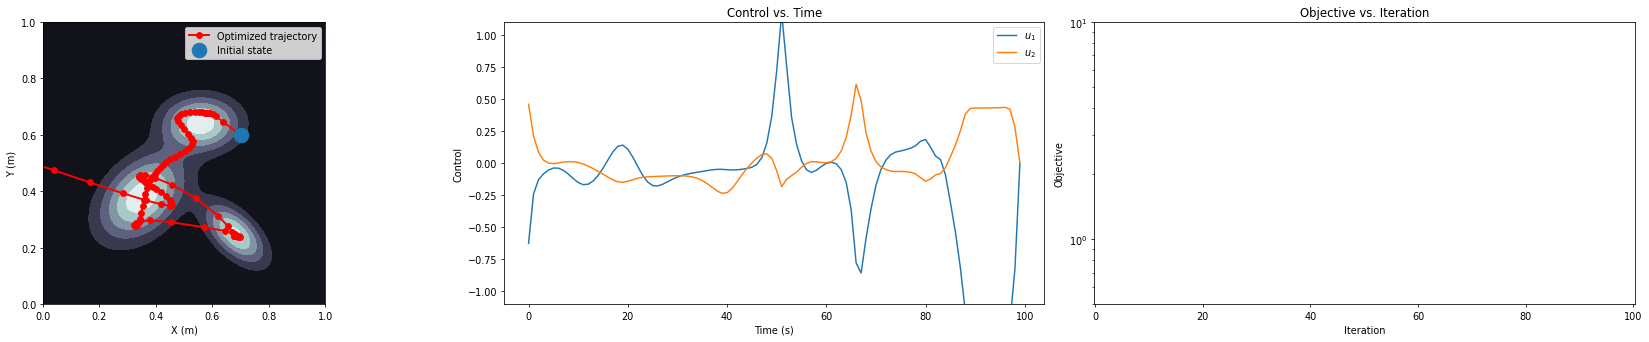

In [262]:
# Iterative trajectory optimization for ergodic control
from IPython import display

loss_list = []

fig, axes = plt.subplots(1, 3, dpi=70, figsize=(25,5), tight_layout=True)

# for iter in tqdm(range(100)):

# solver.solve(max_iter=10, eps=1e-3, alpha=1.00001)
sol = solver.solution
loss_list.append(emmd_loss(sol, args))
U = sol['U']
X = forward_sim(args['x0'], U, args['dt'])[1]

# visualize every 10 iterations
# if (iter+1) % 10 == 0:
ax1 = axes[0]
ax1.cla()
ax1.set_aspect('equal', adjustable='box')
ax1.set_xlim(0.0, L_list[0])
ax1.set_ylim(0.0, L_list[1])
# ax1.set_title('Iteration: {:d}'.format(iter+1))
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='bone')
# ax1.plot([x0[0], x_traj[0,0]], [x0[1], x_traj[0,1]], linestyle='-', linewidth=2, color='k', alpha=1.0)
ax1.plot(X[:,0], X[:,1], linestyle='-', marker='o', color='r', linewidth=2, alpha=1.0, label='Optimized trajectory')
ax1.plot(args['x0'][0], args['x0'][1], linestyle='', marker='o', markersize=15, color='C0', alpha=1.0, label='Initial state')
ax1.legend(loc=1)

ax2 = axes[1]
ax2.cla()
ax2.set_title('Control vs. Time')
ax2.set_ylim(-1.1, 1.1)
ax2.plot(sol['U'][:,0], color='C0', label=r'$u_1$')
ax2.plot(sol['U'][:,1], color='C1', label=r'$u_2$')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Control')
ax2.legend(loc=1)
height = ax1.get_position().height
ax2.set_position([ax2.get_position().x0, ax1.get_position().y0, ax2.get_position().width, height])

ax3 = axes[2]
ax3.cla()
ax3.set_title('Objective vs. Iteration')
ax3.set_xlim(-0.2, 100.2)
ax3.set_ylim(5e-01, 1e1)
ax3.set_xlabel('Iteration')
ax3.set_ylabel('Objective')
# ax3.plot(np.arange(iter+1), loss_list, color='C3')
height = ax1.get_position().height
ax3.set_position([ax3.get_position().x0, ax1.get_position().y0, ax3.get_position().width, height])
ax3.set_yscale('log')

#     display.clear_output(wait=True)
#     display.display(fig)

# display.clear_output(wait=True)
plt.show()
plt.close()

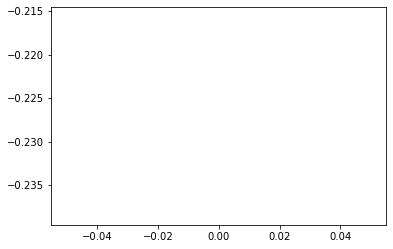

In [263]:
plt.plot(loss_list)